In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!gsutil -m cp gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip  ./

Copying gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][593.6 MiB/593.6 MiB] 100% Done  51.0 MiB/s ETA 00:00:00           
Operation completed over 1 objects/593.6 MiB.                                    


In [ ]:
!unzip -q /content/cats_vs_dogs_dataset.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
train_df = "/content/dataset/train"
test_df = "/content/dataset/test"

In [ ]:
# Define the custom callback function to track and plot training metrics
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        print(f"Epoch {epoch + 1}/{self.params['epochs']} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

In [ ]:
class UploadModel(tf.keras.callbacks.Callback):
    def __init__(self, num_epochs = 10):
      self.num_epochs = num_epochs

    def on_epoch_end(self, epoch, logs=None):
      if (epoch+1) % self.num_epochs == 0:
        filepath = f"/content/models/Cats_vs_Dogs_EffB0-{epoch+1:02d}.h5"
        model_imagenet.save(filepath, include_optimizer=True)
        !gsutil -mq cp {filepath} gs://tibot-ml-labeling/models/cats_vs_dogs_task/shaheer/imagenet_model/model/
        print(f"{filepath} saved in bucket")

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Data preprocessing and augmentation for testing/validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
# Define batch size
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    test_df,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_df,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 17990 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.


In [ ]:
# Create and compile the model (EfficientNetV2 B2 with ImageNet weights)
base_model_imagenet = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x_imagenet = GlobalAveragePooling2D()(base_model_imagenet.output)
x_imagenet = Dense(2, activation='softmax')(x_imagenet)
model_imagenet = Model(inputs=base_model_imagenet.input, outputs=x_imagenet)
model_imagenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model (EfficientNetV2 B2 with ImageNet weights)
history_imagenet = model_imagenet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[CustomCallback(), UploadModel()]  # Use the custom callback for model upload
)

Epoch 1/10
563/563 [==============================] - 356s 533ms/step - loss: 0.1559 - accuracy: 0.9405 - val_loss: 0.9905 - val_accuracy: 0.2612
Epoch 2/10
563/563 [==============================] - 303s 538ms/step - loss: 0.1074 - accuracy: 0.9588 - val_loss: 0.5628 - val_accuracy: 0.7437
Epoch 3/10
563/563 [==============================] - 298s 530ms/step - loss: 0.0807 - accuracy: 0.9693 - val_loss: 0.8263 - val_accuracy: 0.3265
Epoch 4/10
563/563 [==============================] - 295s 524ms/step - loss: 0.0850 - accuracy: 0.9680 - val_loss: 1.0515 - val_accuracy: 0.2593
Epoch 5/10
563/563 [==============================] - 321s 570ms/step - loss: 0.0661 - accuracy: 0.9739 - val_loss: 0.6324 - val_accuracy: 0.7386
Epoch 6/10
563/563 [==============================] - 299s 531ms/step - loss: 0.0660 - accuracy: 0.9754 - val_loss: 0.5503 - val_accuracy: 0.7407
Epoch 7/10
563/563 [==============================] - 296s 525ms/step - loss: 0.0640 - accuracy: 0.9759 - val_loss: 0.6345 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/content/models/Cats_vs_Dogs_EffB0-10.h5 saved in bucket
563/563 [==============================] - 308s 548ms/step - loss: 0.0546 - accuracy: 0.9793 - val_loss: 0.5178 - val_accuracy: 0.7532


In [ ]:
# Get the predictions and ground truth labels
y_pred = np.argmax(model_imagenet.predict(test_generator), axis = 1)
y_true = test_generator.classes

# Create the classification report
classification_report = classification_report(y_true, y_pred, output_dict=True)
print(classification_report)

148/148 [==============================] - 13s 88ms/step
{'0': {'precision': 0.8827382902063544, 'recall': 0.7689015691868759, 'f1-score': 0.8218969197926197, 'support': 3505}, '1': {'precision': 0.5175699821322216, 'recall': 0.7082314588427058, 'f1-score': 0.5980729525120441, 'support': 1227}, 'accuracy': 0.7531699070160609, 'macro avg': {'precision': 0.700154136169288, 'recall': 0.7385665140147908, 'f1-score': 0.7099849361523318, 'support': 4732}, 'weighted avg': {'precision': 0.78805073441452, 'recall': 0.7531699070160609, 'f1-score': 0.7638597245573563, 'support': 4732}}


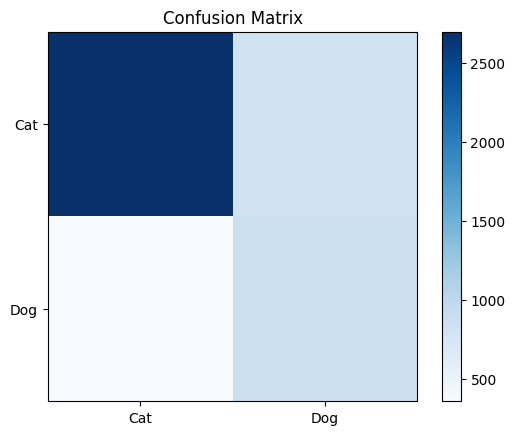

TypeError: ignored

In [ ]:
# Create the confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(range(2), ['Cat', 'Dog'])
plt.yticks(range(2), ['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.show()


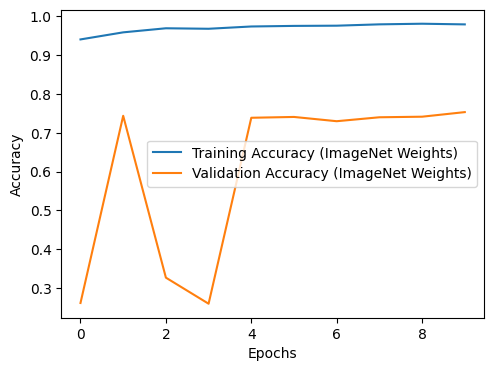

In [ ]:
# Plot training metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_imagenet.history['accuracy'], label='Training Accuracy (ImageNet Weights)')
plt.plot(history_imagenet.history['val_accuracy'], label='Validation Accuracy (ImageNet Weights)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()